# HW 7: Magnets

Haylen Gerhard

May 17, 2023

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy as sp
from ipywidgets import interact, IntSlider

## WHY

Here, we are finding the Curie temperature of a 2D Ising Magnet. In more words, we are finding the temperature at which the average magnetization is ~0.5 for a 2D grid of spins that can have individual magnetizations of $\pm1$.

## WHAT
We find the Curie temperature using Monte-Carlo methods, specifically simulated annealing. The optimization process goes like this.



1. Pick some lattice site at random.
2. Calculate the energy change, $\Delta E$, that would occur from flipping the spin on the lattice.
3. If $\Delta E < 0$, keep the change.
4. If  $\Delta E > 0$, keep the change with probability $exp[\frac{-\Delta E}{kT}]$ where kT is some chosen temperature.
5. Repeat steps 1-4 until convergence is reached.


We define the interaction energy between two spins in the usual way,

$$
E_{mn} = -J(\mu_m \cdot \mu_n) 
$$

where $\mu_n$ is the magnetic moment of a given lattice site and $J=1$ is the interaction strength. Here, we only consider nearest-neighbor interactions and consider convergence to be when the average magnetization over time is constant.

In [ ]:
# defining all the machinery

def plotColor(slide,title=None) :

  x,y = range(len(slide)), range(len(slide[0]))

  X,Y = np.meshgrid(x,y)

  fig0, ax0 = plt.subplots()
  ax0.set_ylabel("y")
  ax0.set_xlabel("x")
  if title == None :
    ax0.set_title("Color Plot of Voltage")
  else :
    ax0.set_title(title)
  ax0.scatter(X,Y,s=1,c = slide, cmap="viridis")

  plt.set_cmap('viridis')
 
  
  plot = ax0.pcolor(slide)
  fig0.colorbar(plot,label="Particle Density")
  fig0.show()

  return fig0,ax0

def animateColorPlot(data,time) :

  # Create function to update plot
  def update_plot(index):
      plt.imshow(data[index], cmap='viridis')
      plt.title(f'Time: {index}')
      plt.show()

  # Create interactive slider
  slider = IntSlider(value=0, min=0, max=time - 1, step=1, description='Time')

  # Connect slider to update function
  interact(update_plot, index=slider)

  # Display initial plot
  update_plot(0)

def distance(v1,v2) :

  dist = 0

  for ii in range(len(v1)) :
    for jj in range(len(v1[0])) :
      dist += abs(v1[ii][jj]-v2[ii][jj])
  return dist


class sim_params() :
  dx = 1
  dt = 1
  D = 0.2
  N = 50
  timeSteps = 300

  amp = .2
  sigma = 0.05
  x_center = 0.3

  x = np.array(range(0,N))*dx

  ymesh = None
  xmesh = None
  spins = None
  spins = None
  E = None
  EavgSlides = []
  EavgGridSlides = []
  M = None
  MPlot = None
  MavgSlides = []

  timeSlides = None
  slideStep = 5
  numSlides = None





  



class sim_string(sim_params) :

  

  def initialize(self,hot=True) :

    randArr = [-1,1]
    
    self.spins = np.ones((self.N,self.N))
    if hot==True :
      for ii in range(len(self.spins)) :
        for jj in range(len(self.spins[0])) :
          self.spins[ii,jj] = randArr[random.randint(0,1)]

    self.timeSlides = np.zeros((self.timeSteps,self.N, self.N))
    self.updateE()

    x,y = range((self.N)), range((self.N))

    self.xmesh, self.ymesh = np.meshgrid(x,y)

  def updateE(self) :
    spinright = np.roll(self.spins,-1,axis=1)
    spinleft = np.roll(self.spins,1,axis=1)
    spinabove = np.roll(self.spins,1,axis=0)
    spinbelow = np.roll(self.spins,-1,axis=0)

    self.E = -1*self.spins * (spinright + spinleft + spinabove + spinbelow)

  def updateM(self) :
    self.M = np.sum(self.spins)

  def getAvgE(self,mode="int") :
    self.updateE()
    if mode=="int" :
      return np.sum(np.average(self.E))
    elif mode=="arr" :
      return np.average(self.E)

  def getAvgM(self,mode="int") :
    self.updateM()
    if mode=="int" :
      return np.sum(np.average(self.spins))
    elif mode=="arr" :
      return np.average(self.M)

  def evolveDiffusion(self) :

    slideCounter = 0

    for tt in range(self.timeSteps) : 
      #self.spins[1:-1][1:-1] += (self.D*self.dt/self.dx**2)*(self.spins[:-2,1:-1] + self.spins[2:,1:-1] +
                                                             #self.spins[1:-1,:-2] + self.spins[1:-1,2:] -
                                                             #4*self.spins[1:-1,1:-1])
      self.spins += (self.D*self.dt/self.dx**2)*sp.ndimage.laplace(self.spins,mode="constant")

      self.timeSlides[slideCounter] = np.copy(self.spins)
      slideCounter += 1

  def optimizeMC(self,kT,epochs) :

    self.MPlot = np.zeros(epochs*(self.N**2))
    self.EPlot = np.zeros(epochs*(self.N**2))
    self.updateE()

    for run in range(epochs*(self.N**2)) :
      i = np.random.choice(range(self.N))
      j = np.random.choice(range(self.N))
      

      if self.E[i,j] >= 0 :
        self.spins[i,j] *= -1
        self.updateE()
      elif random.random() <= np.exp(2*self.E[i,j]/kT) :
        self.spins[i,j] *= -1
        self.updateE()

      self.MPlot[run] = self.getAvgM()
      self.EPlot[run] = self.getAvgE()
      





  def placeGaussian(self,centerIndex=30) :
    self.spins[1:-1] += self.amp*np.exp(-(self.x[1:-1] - centerIndex*self.dx)**2/(2*self.sigma**2))



  def animate(self,ptime = 1, tStep = 5) :

    for index in range(len(self.timeSlides) // tStep) :

      plotColor(title=f"t = {tStep*index} (in units of dt)",slide=self.timeSlides[index*tStep])
      plt.pause(ptime)



Let's figure out how many Monte-Carlo(MC) runthroughs of the lattice we need to get convergence, no matter the temperature or starting configuration.

In [ ]:
khot = sim_string()
khot.N = 12
khot.initialize(hot=False)

kcold = sim_string()
kcold.N = 12
kcold.initialize(hot=True)


khot.optimizeMC(5,1000)
kcold.optimizeMC(1,100)


Text(0.5, 0, '"Time"')

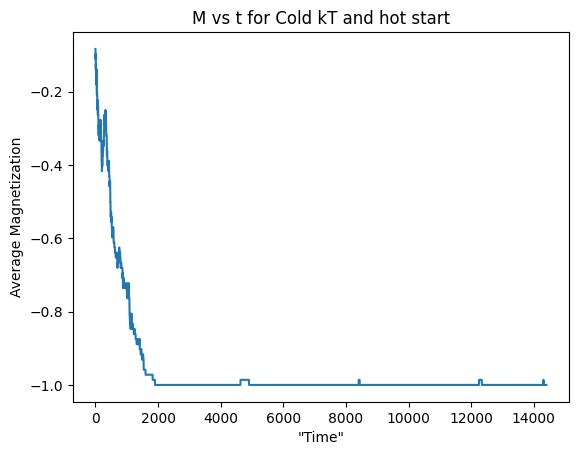

In [ ]:
plt.plot(kcold.MPlot)
plt.title("M vs t for Cold kT and hot start")
plt.ylabel("Average Magnetization")
plt.xlabel("\"Time\"")

Text(0.5, 0, '"Time"')

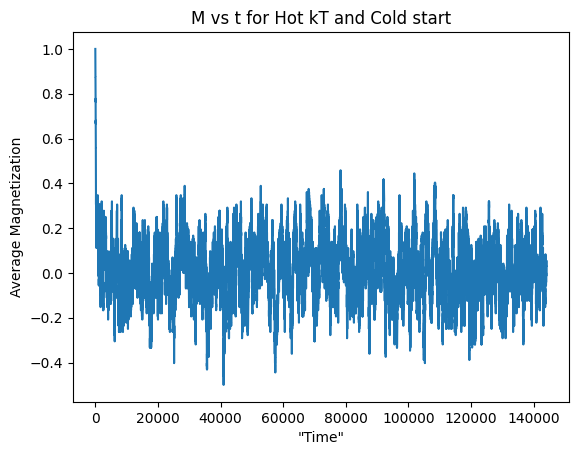

In [ ]:
plt.plot(khot.MPlot)
plt.title("M vs t for Hot kT and Cold start")
plt.ylabel("Average Magnetization")
plt.xlabel("\"Time\"")

For a hot start and a cold temperature, we see that after around 4000 MC runthroughs (or around 30 runs through the lattice) we get convergent behavior. However, I keep getting some of my cold runs as staying at a low magnetization, so I'm going to do 500 runs through the lattice and keep the last ~400 runs.

In [ ]:
res = 50
magPlot = np.zeros(res)
tempPlot = np.linspace(1,5,res)


for ii in range(res) :
  k = sim_string()
  k.N = 12
  k.initialize(hot=True)
  k.optimizeMC(tempPlot[ii],500)

  magPlot[ii] = abs(np.sum(np.average(k.MPlot[40000:])))




Text(0.5, 0, 'Temperature')

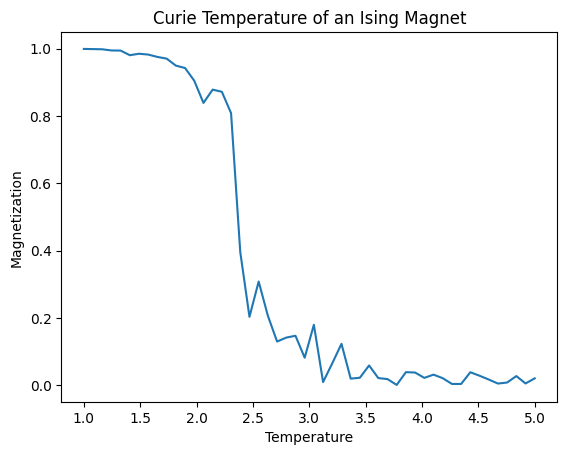

In [ ]:
plt.plot(tempPlot,magPlot)
plt.title("Curie Temperature of an Ising Magnet")
plt.ylabel("Magnetization")
plt.xlabel("Temperature")

## SO WHAT
From this plot, we can see that the Curie temperature is right around 2.25 for a 12x12 grid of spins. Given that the exacct Curie temperature of an Ising magnet is 2.2691853... for an interaction strength of 1, I'd say this is a fine approximation of the behavior.